In [2]:
import collections
from datetime import datetime
import os
import random

import keras
from keras import layers, models, optimizers
from keras.applications import VGG16
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import decimate, savgol_filter, spectrogram
from sklearn import model_selection
import tensorflow as tf

# The Problem 

This problem is about predicting the time to eruption of a volcano given time series siesmic sensor data collected over a 24-hr period. The exact nature of the sensors are not described in the problem, nor are the units. The problem is described in detail [here](https://www.kaggle.com/c/predict-volcanic-eruptions-ingv-oe).

Data for each volcano is made available as a single CSV consisting of 10 columns, corresponding to 10 siesmic sensors. Not all files contain all the sensors, and in some cases, some of the sensors contain faulty data (such as all 0s or a high railed value). The dataset consisted of 4431 training samples, and 4520 test samples. The contest was judged on the basis of the lowest MAE that could be achieved for the test data. 

# General Approach

* **Pre-analysis**
    * Write functions to load time-series data from CSV files and the corresponding time-to-eruption.
    * Plot and inspect signals to observe general trends and / or and obvious time-domain or frequency-domain features.
* **Data Preparation**
    * Handle missing-sensor signals.
    * **Time-domain**
        * Observed some of the sensors showed high frequency, zero-mean oscillations in the traces. Extracted the amplitude envelope of the signals using a combination of rolling window averaging, and Savitzky-Golay filtering. Decimated this derived amplitude trace since it didn't contain high frequency signals anymore.
    * **Frequency-domain**
        * Use STFT (spectrogram). Use `log` transform to compress the frequency domain information.
        * Concat all 10 (corresponding to the 10 siesmic sensors) log-transformed spectrograms into a single image in preperation for using computer-vision based ML techniques on it.
    * Scale time-domain and frequency-domain freatures so they are ~1.
    * Save preprocessed data in files.
* **Training and Validation**
    * Hold 5% of training data back for validation. 
    * Write a data generator (subclassing `keras.Sequence`) for training and validation.
    * Build `keras` based neural network ML model with two branches that accept 3 sets of inputs, time-domain, frequency-domain, and scale respectively. Each branch extracts features which are then fed into a set of dense layers for regression.
        * **Time-domain**
            * Sequence analysis using a combination of `CONV1D` and RNN (bidirectinoal `LSTM`).
        * **Frequency-domain**
            * Image based model using `CONV2D` and `MaxPooling` layers.
    * Iterate on the design of the time-domain and frequency-domain branches.
    * Iterate on the hyperparameters of the model.


## Helper Functions

In [4]:
print(f"Train: {len(os.listdir('train'))}")
print(f"Test: {len(os.listdir('test'))}")

Train: 4431
Test: 4520


In [3]:
def show_file(file_id=None, what='train'):
    """Return a random or requested file."""
    if file_id is None:
        all_files = os.listdir(what)
        data_file = random.sample(all_files, 1)[0]
        file_id, _ = os.path.splitext(data_file)
        print(f'file_id: {file_id}')
    
    if what == 'train':
        label_df = pd.read_csv(f'{what}.csv')
    else: 
        label_df = pd.read_csv('sample_submission.csv')    
    df = pd.read_csv(os.path.join(os.getcwd(), what, f'{file_id}.csv'))
    label = label_df[label_df['segment_id'] == int(file_id)].iloc[0, 1]
    return df, label

In [25]:
df, label = show_file(362806359)
#df, label = show_file()
print("Shape of DataFrame: ", df.shape)
print("Time to Eruption: ", label)

Shape of DataFrame:  (60001, 10)
Time to Eruption:  15046200


### Examples of raw sensor signals 

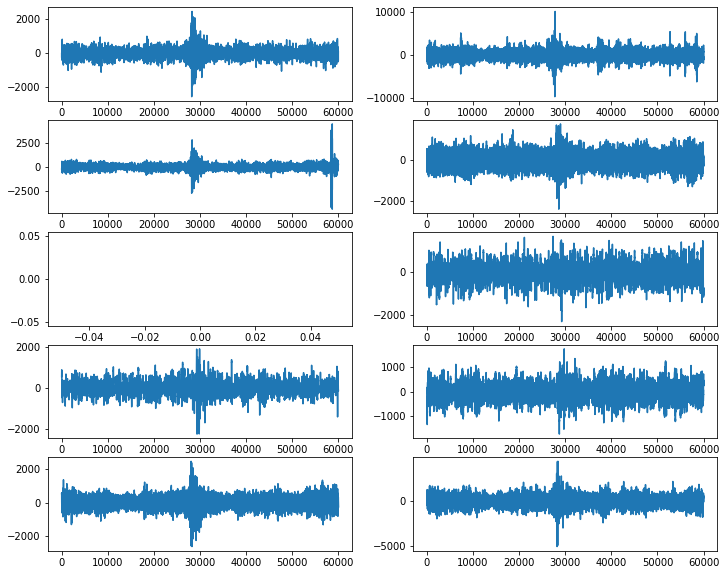

In [27]:
fig = plt.figure(figsize=(12, 10))

for i in range(10):
    plt.subplot(5, 2, i + 1)
    plt.plot(df.iloc[:,i])

## ML Solution 

### Step 1: Impute missing data, scale sensor signals, and aggregate scaling constants

In [4]:
TD_SCALE = 20
MAD_SCALE = 200

def impute_and_scale(df):
    df_scaled = df.copy()
    df_scaled.fillna(value=0, inplace=True)
    scaling = []
    for col in df.columns:
        magn = df_scaled[col].abs().max()
        magn_mad = (df_scaled[col] - df_scaled[col].median()).abs().median()
        scaling.append(magn_mad / MAD_SCALE)
        if magn_mad:
            df_scaled[col] = df_scaled[col] / magn_mad
    
    return df_scaled / TD_SCALE, scaling 
    

In [29]:
df_scaled, scaling = impute_and_scale(df)

### Examples of sensor signals (zoomed in in time), after scaling and imputing missing values

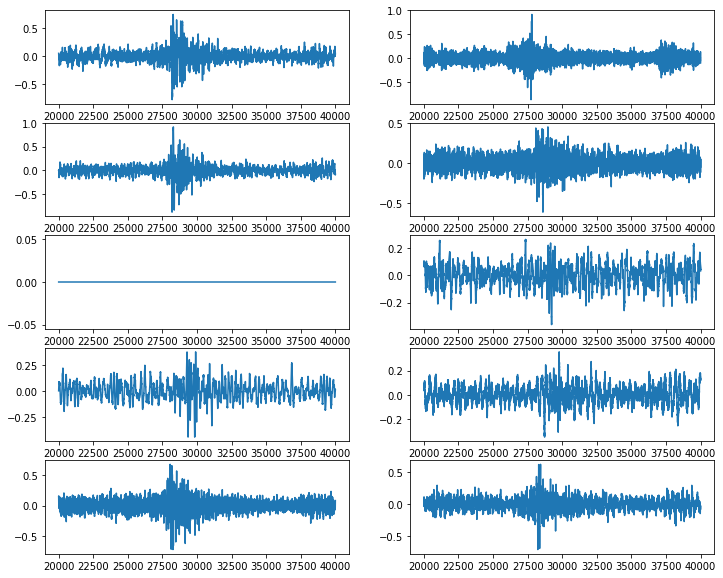

In [64]:
fig = plt.figure(figsize=(12, 10))

for i in range(10):
    plt.subplot(5, 2, i + 1)
    plt.plot(df_scaled.iloc[20000:40000,i])

### Histogram of aggregated scaling constants for 10 sensors

<AxesSubplot:>

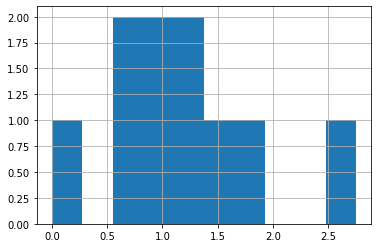

In [31]:
pd.Series(scaling).hist()

### Step 2: Preprocess sensor signals in time-domain

In [5]:
FS = 100
PEAK_WIN = FS // 4
WIN = 2 * FS if 2 * FS % 2 else 2 * FS + 1
POLY_ORDER = 1
DECIMATE_FACT = 64

def td_preprocessing(df_scaled):
    df_td = pd.DataFrame()
    for col in df_scaled.columns:
        peaks = df_scaled[col].abs().rolling(PEAK_WIN, min_periods=0).max()
        output = savgol_filter(peaks, WIN, POLY_ORDER)
        filtered_4 = decimate(output, 4)
        filtered_16 = decimate(filtered_4, 4)
        filtered_64 = decimate(filtered_16, 4)
        df_td[col] = filtered_64
    return df_td

In [33]:
df_td = td_preprocessing(df_scaled)

In [34]:
df_td.shape

(938, 10)

### Preprocessing applied in the time-domain to a single sensor signal

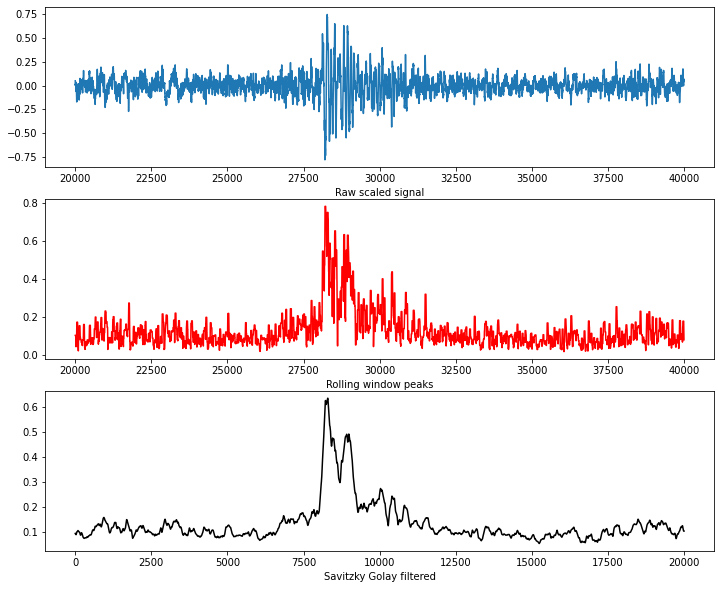

In [38]:
sig = df_scaled.iloc[:,0]
peaks = sig.abs().rolling(PEAK_WIN, min_periods=0).max()
output = savgol_filter(peaks, WIN, POLY_ORDER)

fig = plt.figure(figsize=(12,10))
plt.subplot(311)
plt.plot(sig[20000:40000])
plt.xlabel('Raw scaled signal')
plt.subplot(312)
plt.plot(peaks[20000:40000], 'r')
plt.xlabel('Rolling window peaks')
plt.subplot(313)
plt.plot(output[20000:40000], 'k')
_ = plt.xlabel('Savitzky Golay filtered')

### Preprocessed sensor signals from all 10 sensors

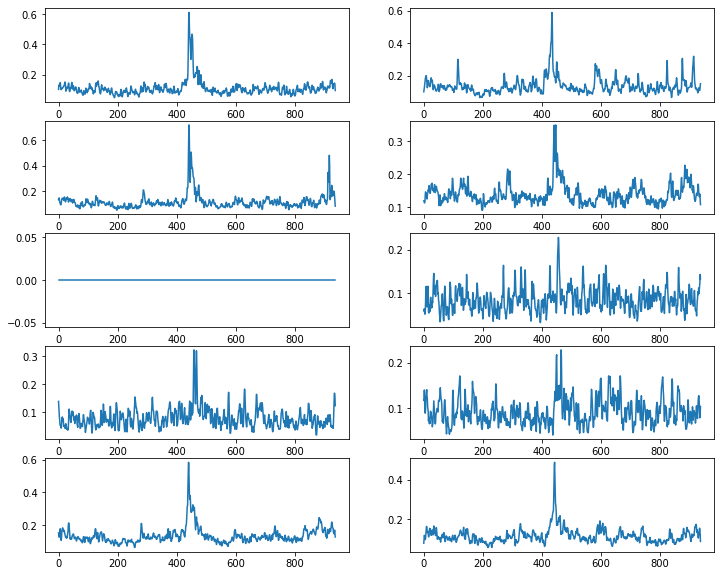

In [35]:
fig = plt.figure(figsize=(12, 10))

for i in range(10):
    plt.subplot(5, 2, i + 1)
    plt.plot(df_td.iloc[:,i])

### Step 3: Preprocess sensor signals in frequency domain

In [6]:
FS = 100
NPERSEG = 64
NFFT = 64  # 100 / 64 = 1.56 Hz frequency resolution
FD_SCALE = 25
ZERO_SUB = 1e-14

def sub_zeros(sxx):
    sxx = sxx.copy()
    idx = np.where(sxx==0)[0]
    sxx[idx] = ZERO_SUB
    return sxx

def fd_preprocessing(df_scaled):
    fd_img_list = []
    for col in df_scaled.columns:
        f, t, sxx = spectrogram(df_scaled[col], fs=FS, nperseg=NPERSEG, nfft=NFFT)
        sxx = sub_zeros(sxx)
        sxx_scaled = np.log(sxx) / FD_SCALE
        fd_img_list.append(sxx_scaled)
    return np.vstack(fd_img_list)

In [40]:
fd_img = fd_preprocessing(df_scaled)

### Preprocessed signals in the frequency domain (spectrograms concatentated into a single image)

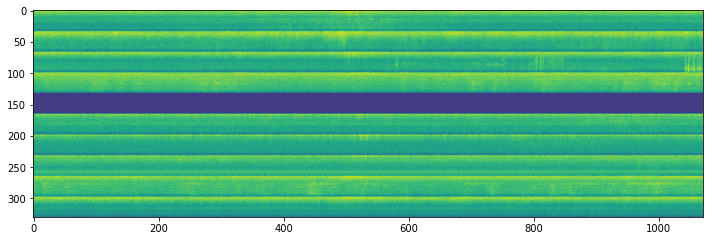

In [58]:
fig = plt.figure(figsize=(12, 10))
fig.set_size_inches((12, 4))
_ = plt.imshow(fd_img)

### Step 4: Scale labels (y) 

In [7]:
train_df = pd.read_csv('train.csv')
labels = train_df['time_to_eruption']
MEAN_LABELS = labels.mean()
STD_LABELS = labels.std()

def scale_label(y):
    y_scaled = (y - MEAN_LABELS) / STD_LABELS
    return y_scaled

def inverse_scale_labels(y_pred_scaled):
    y_pred = y_pred_scaled * STD_LABELS + MEAN_LABELS
    y_pred = [int(x * STD_LABELS + MEAN_LABELS) for x in y_pred_scaled]
    return y_pred

### Histogram of raw label values

<AxesSubplot:>

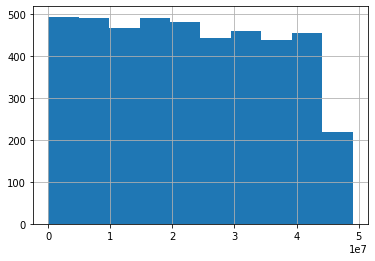

In [60]:
train_df = pd.read_csv('train.csv')
labels = train_df['time_to_eruption']
labels.hist()

### Histogram of scaled label values

<AxesSubplot:>

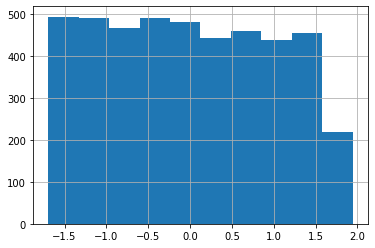

In [61]:
y_scaled = scale_label(labels.values)
pd.Series(y_scaled).hist()

### Step 5: Build ML model

In [8]:
def preprocess(what='train'):
    if not os.path.exists(os.path.join('keya_preprocessed', what)):
        os.makedirs(os.path.join('keya_preprocessed', what))
    
    all_files = [x for x in os.listdir(what) if x.endswith('.csv')]
    for file in all_files:
        file_id, _ = os.path.splitext(file)
        file_id = int(file_id)
        df, label = show_file(file_id, what)
        df_scaled, scaling = impute_and_scale(df)
        df_td = td_preprocessing(df_scaled)
        fd_img = fd_preprocessing(df_scaled)

        td_array = np.array(df_td)
        fd_img_array = np.expand_dims(fd_img, -1)
        y = scale_label(label)
        
        np.save(os.path.join('keya_preprocessed', what, f'{file_id}.npy'), np.array([td_array, fd_img_array, scaling, y], dtype='object'))
    

In [ ]:
preprocess('train')

In [110]:
class DataGenPreprocessOnTheFly(keras.utils.Sequence):
    
    def __init__(self, files, what='train', batch_size=16):
        self.what = what
        self.batch_size = batch_size
        
        self.all_files = files #[x for x in os.listdir(self.what) if x.endswith('csv')]
        random.shuffle(self.all_files)
        
    def __len__(self):    
        return int(np.ceil(len(self.all_files) / self.batch_size))
        
    def __getitem__(self, batch_num):
        td_all = []
        fd_img_all = []
        scaling_all = []
        y = []
        all_files = self.all_files
        batch_size = self.batch_size
        for file in all_files[batch_num * batch_size: (batch_num + 1) * batch_size]:
            file_id, _ = os.path.splitext(file)
            file_id = int(file_id)
            df, label = show_file(file_id, self.what)
            df_scaled, scaling = impute_and_scale(df)
            df_td = td_preprocessing(df_scaled)
            fd_img = fd_preprocessing(df_scaled)
            
            td_all.append(np.array(df_td))
                        
            fd_img_all.append(np.expand_dims(fd_img, -1))
            
            scaling_all.append(scaling) 
            
            y.append(scale_label(label))
        return (np.array(td_all), np.array(fd_img_all), np.array(scaling_all)), np.array(y)
        
    def on_epoch_end(self):
        random.shuffle(self.all_files)

In [9]:
class DataGen(keras.utils.Sequence):
    
    def __init__(self, files, what='train', batch_size=16, shuffle=True):
        self.what = what
        self.batch_size = batch_size
        self.shuffle = shuffle
        
        self.all_files = files 
        #random.shuffle(self.all_files)
        
    def __len__(self):    
        return int(np.ceil(len(self.all_files) / self.batch_size))
        
    def __getitem__(self, batch_num):
        td_all = []
        fd_img_all = []
        scaling_all = []
        y_all = []
        all_files = self.all_files
        batch_size = self.batch_size
        for file in all_files[batch_num * batch_size: (batch_num + 1) * batch_size]:
            file_id, _ = os.path.splitext(file)
            file_id = int(file_id)
            
            td, fd, scaling, y = np.load(os.path.join('keya_preprocessed', self.what, file), allow_pickle=True)
            
            td_all.append(td)
            fd_img_all.append(fd)
            scaling_all.append(scaling) 
            y_all.append(y)
            
        return (np.array(td_all), np.array(fd_img_all), np.array(scaling_all)), np.array(y_all) 
        
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.all_files)

In [10]:
all_files = [p for p in os.listdir('keya_preprocessed/train') if p.endswith('npy')]
train_files, val_files = model_selection.train_test_split(all_files, test_size=0.05)

In [11]:
train_gen = DataGen(train_files, 'train', batch_size=16)
val_gen = DataGen(val_files, 'train', batch_size=16)

In [12]:
x, y = train_gen[0]

print(x[0].shape)
print(x[1].shape)
print(x[2].shape)
print(y.shape)

(16, 938, 10)
(16, 330, 1071, 1)
(16, 10)
(16,)


In [13]:
def build_model():
    td_inp = keras.Input(shape=(938, 10), name='td_inp')
    fd_inp = keras.Input(shape=(330, 1071, 1), name='fd_inp')
    scaling_inp = keras.Input(shape=(10,), name='scaling_inp')
    
    # Time domain
    x = layers.Conv1D(64, 7, activation='relu')(td_inp)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(128, 7, activation='relu')(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(256, 7, activation='relu')(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(128))(x)
    time_output = layers.Dropout(0.2)(x)
    
    
    # Freq Domain
    x = layers.Conv2D(32, (3, 3), activation='relu')(fd_inp)
    x = layers.MaxPool2D((1, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPool2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.MaxPool2D((2, 2))(x)
    x = layers.Conv2D(256, (3, 3), activation='relu')(x)
    x = layers.MaxPool2D((2, 2))(x)
    x = layers.Conv2D(256, (3, 3), activation='relu')(x)
    x = layers.MaxPool2D((2, 2))(x)
    x = layers.Conv2D(256, (3, 3), activation='relu')(x)
    x = layers.MaxPool2D((2, 2))(x)
    x = layers.Conv2D(256, (3, 3), activation='relu')(x)
    x = layers.MaxPool2D((2, 2))(x) 
    x = layers.Flatten()(x)
    freq_output = layers.Dropout(0.2)(x)
    
    
    concatenated = layers.concatenate([time_output, freq_output, scaling_inp], axis=-1)
    x = layers.Dense(128, activation='relu')(concatenated)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    out = keras.layers.Dense(1)(x)
    
    model = keras.Model(inputs=[td_inp, fd_inp, scaling_inp], outputs=out)
    model.compile(
        loss='mae',
        optimizer=keras.optimizers.Adam(1e-4),
        metrics=['mae'],
    )
    
    return model

In [14]:
model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
fd_inp (InputLayer)             [(None, 330, 1071, 1 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 328, 1069, 32 320         fd_inp[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 328, 534, 32) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 326, 532, 64) 18496       max_pooling2d[0][0]              
______________________________________________________________________________________________

In [15]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint('keya_model.h5', save_best_only=True, monitor='mae'),
]

history = model.fit(train_gen, 
                    callbacks=callbacks_list,
                    validation_data=val_gen, 
                    epochs=400,
                    verbose=1,
                    )
                    

Epoch 1/400
264/264 [==============================] - 123s 439ms/step - loss: 0.8061 - mae: 0.8061 - val_loss: 0.7336 - val_mae: 0.7336
Epoch 2/400
264/264 [==============================] - 97s 367ms/step - loss: 0.7148 - mae: 0.7148 - val_loss: 0.6934 - val_mae: 0.6934
Epoch 3/400
264/264 [==============================] - 90s 339ms/step - loss: 0.5909 - mae: 0.5909 - val_loss: 0.5437 - val_mae: 0.5437
Epoch 4/400
264/264 [==============================] - 88s 335ms/step - loss: 0.5086 - mae: 0.5086 - val_loss: 0.4909 - val_mae: 0.4909
Epoch 5/400
264/264 [==============================] - 86s 326ms/step - loss: 0.4829 - mae: 0.4829 - val_loss: 0.4615 - val_mae: 0.4615
Epoch 6/400
264/264 [==============================] - 86s 324ms/step - loss: 0.4364 - mae: 0.4364 - val_loss: 0.4153 - val_mae: 0.4153
Epoch 7/400
264/264 [==============================] - 86s 325ms/step - loss: 0.4056 - mae: 0.4056 - val_loss: 0.3946 - val_mae: 0.3946
Epoch 8/400
264/264 [==========================

Min Validation MAE:  0.04309237375855446


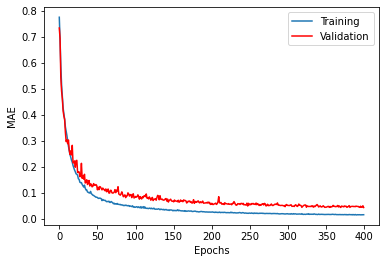

In [16]:
plt.plot(history.history['mae'], label='Training')
plt.plot(history.history['val_mae'], 'r', label='Validation')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

print("Min Validation MAE: ", np.min(history.history['val_mae']))

### Step 6: Inference

In [9]:
preprocess('test')

In [10]:
sample_subm = pd.read_csv('sample_submission.csv')
test_files = [f'{x}.npy' for x in sample_subm['segment_id']]

In [11]:
no_of_test_files = len(test_files)
test_gen = DataGen(test_files, 'test', batch_size=10, shuffle=False)
model = keras.models.load_model('keya_model.h5')

In [12]:
print(no_of_test_files)

4520


In [13]:
BATCH_SIZE = 10

y_final = []
for batch in range(int(np.ceil(no_of_test_files / BATCH_SIZE))):
    y_final_scaled = model.predict(test_gen[batch][0])
    y_final.extend(inverse_scale_labels(y_final_scaled))



In [14]:
sample_subm['time_to_eruption'] = y_final
sample_subm.to_csv('keya_subm.csv', index=False)